In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch import nn

Dataset downloaded successfully!
Dataset loaded:
         Date  Price
0  1997-01-07   3.82
1  1997-01-08   3.80
2  1997-01-09   3.61
3  1997-01-10   3.92
4  1997-01-13   4.00
Epoch [1/100], Loss: 0.0003
Epoch [11/100], Loss: 0.0001
Epoch [21/100], Loss: 0.0001
Epoch [31/100], Loss: 0.0001
Epoch [41/100], Loss: 0.0001
Epoch [51/100], Loss: 0.0001
Epoch [61/100], Loss: 0.0005
Epoch [71/100], Loss: 0.0002
Epoch [81/100], Loss: 0.0003
Epoch [91/100], Loss: 0.0002


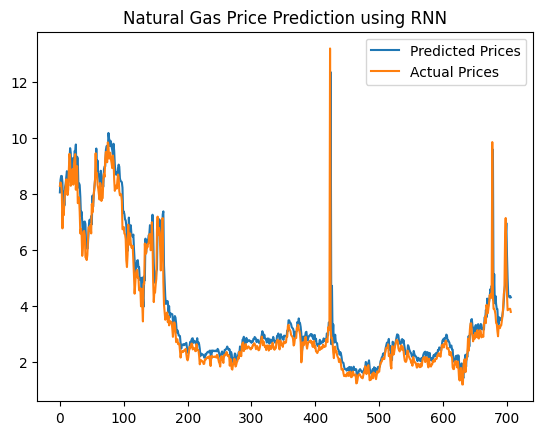

In [2]:
import requests
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Step 1: Download the dataset
url = "https://datahub.io/core/natural-gas/r/daily.csv"  # Direct URL to the daily CSV file
response = requests.get(url)

# Save the content to a CSV file locally
with open("daily_natural_gas.csv", "wb") as file:
    file.write(response.content)

print("Dataset downloaded successfully!")

# Step 2: Load and preprocess the dataset
df = pd.read_csv("daily_natural_gas.csv")

# Display the first few rows to inspect the data
print("Dataset loaded:")
print(df.head())

# Step 3: Drop any rows with missing values
df = df.dropna()

# Normalize the 'Price' column (Min-Max scaling)
y = df['Price'].values
minm = y.min()
maxm = y.max()
y = (y - minm) / (maxm - minm)

# Step 4: Create sequences of length 10 for input and 1 for output
Sequence_Length = 10
X = []
Y = []

for i in range(0, len(y) - Sequence_Length):
    list1 = []
    for j in range(i, i + Sequence_Length):
        list1.append(y[j])
    X.append(list1)
    Y.append(y[i + Sequence_Length])

# Convert X and Y to numpy arrays
X = np.array(X)
Y = np.array(Y)

# Step 5: Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=42, shuffle=False)

# Step 6: Convert data to PyTorch tensors and create Dataset class
class NGTimeSeries(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.len = x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return self.len

train_dataset = NGTimeSeries(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Step 7: Define the RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc1 = nn.Linear(in_features=hidden_size, out_features=1)

    def forward(self, x):
        # x: (batch_size, seq_length, input_size)
        out, _ = self.rnn(x)  # out: (batch_size, seq_length, hidden_size)
        out = out[:, -1, :]  # Taking the last time step's output
        out = self.fc1(out)  # Linear layer to get the predicted price
        return out

# Step 8: Initialize the model, loss function, and optimizer
model = RNNModel(input_size=1, hidden_size=64, num_layers=1)
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Step 9: Training loop
epochs = 100
for epoch in range(epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        # Reshaping input to (batch_size, seq_length, input_size)
        inputs = inputs.view(-1, Sequence_Length, 1)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.view(-1), labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# Step 10: Test the model
# Prepare the test set
model.eval()  # Set model to evaluation mode
test_inputs = torch.tensor(x_test, dtype=torch.float32).view(-1, Sequence_Length, 1)
test_labels = torch.tensor(y_test, dtype=torch.float32)

# Predict on test set
with torch.no_grad():
    predictions = model(test_inputs).view(-1)

# Denormalize the predictions and actual values
predictions = predictions.numpy() * (maxm - minm) + minm
test_labels = test_labels.numpy() * (maxm - minm) + minm

# Step 11: Plot the results
plt.plot(predictions, label="Predicted Prices")
plt.plot(test_labels, label="Actual Prices")
plt.legend()
plt.title("Natural Gas Price Prediction using RNN")
plt.show()


In [3]:
import os
import glob
import unicodedata
import string
import torch
import torch.nn as nn
import torch.optim as optim
import random

# --- Data Preparation ---

# Define all valid characters and count them.
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicodeToAscii(s):
    """
    Convert a Unicode string to plain ASCII.
    Ensures all names are in a standard format.
    """
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn' and c in all_letters
    )

def load_data(data_path):
    """
    Loads names from text files in the given folder.
    Each file corresponds to a language and contains a list of names.
    Returns a dictionary mapping language -> list of names and a list of all languages.
    """
    category_lines = {}
    all_categories = []
    
    # Check if the data_path exists
    if not os.path.exists(data_path):
        print(f"Data path '{data_path}' does not exist. Please check your path.")
        return category_lines, all_categories

    # Get list of all .txt files in the directory
    file_list = glob.glob(os.path.join(data_path, '*.txt'))
    if not file_list:
        print(f"No '.txt' files found in '{data_path}'.")
        return category_lines, all_categories

    # Process each file
    for filename in file_list:
        category = os.path.splitext(os.path.basename(filename))[0]
        all_categories.append(category)
        # Read each file and convert names to ASCII, filtering out empty lines.
        with open(filename, encoding='utf-8') as f:
            lines = f.read().strip().split('\n')
            lines = [unicodeToAscii(line) for line in lines if line.strip()]
        category_lines[category] = lines
    return category_lines, all_categories

# Set the data path to where your names files are stored.
data_path = "./data/data/names"
category_lines, all_categories = load_data(data_path)

# Debug: print loaded languages
print("Loaded languages:", all_categories)
if not all_categories:
    raise ValueError("No languages loaded. Check your data directory and file contents.")

n_categories = len(all_categories)
print(f"Total languages loaded: {n_categories}")

# --- Helper Functions for Encoding ---

def letterToIndex(letter):
    """
    Returns the index of the given letter in all_letters.
    """
    return all_letters.find(letter)

def lineToTensor(line):
    """
    Converts a name (string) into a tensor of shape (line_length, 1, n_letters).
    Each character is represented as a one-hot vector.
    """
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        index = letterToIndex(letter)
        if index != -1:
            tensor[li][0][index] = 1
    return tensor

def randomTrainingExample():
    """
    Selects a random language and a random name from that language.
    Returns the language, the name, the one-hot encoded name tensor, 
    and the target category as a tensor.
    """
    category = random.choice(all_categories)
    line = random.choice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, line_tensor, category_tensor

# --- Define the RNN Model ---

class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNClassifier, self).__init__()
        self.hidden_size = hidden_size
        # Combine input and hidden state, then project to new hidden state.
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        # Combine input and hidden state, then project to output space (language scores).
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input, hidden):
        # Concatenate input and previous hidden state.
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        # Initialize the hidden state as zeros.
        return torch.zeros(1, self.hidden_size)

# Set hyperparameters and instantiate the model.
n_hidden = 128
rnn = RNNClassifier(n_letters, n_hidden, n_categories)

# --- Training Setup ---

criterion = nn.NLLLoss()   # Negative log likelihood loss
learning_rate = 0.005
optimizer = optim.SGD(rnn.parameters(), lr=learning_rate)

n_iters = 100000
print_every = 5000
current_loss = 0

# --- Training Loop ---
for iter in range(1, n_iters + 1):
    category, line, line_tensor, category_tensor = randomTrainingExample()
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    # Process the name one character at a time.
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()
    
    current_loss += loss.item()
    if iter % print_every == 0:
        avg_loss = current_loss / print_every
        current_loss = 0
        print(f"Iteration {iter} Loss: {avg_loss:.4f}")

# --- Evaluation Functions ---

def evaluate(line_tensor):
    """
    Evaluates a given name tensor by processing it through the RNN.
    Returns the output scores from the final time step.
    """
    hidden = rnn.initHidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    return output

def predict(input_line, n_predictions=1):
    """
    Given an input name (string), prints out the top predictions
    for the language of origin along with their associated scores.
    """
    print(f"\n> {input_line}")
    output = evaluate(lineToTensor(input_line))
    topv, topi = output.topk(n_predictions)
    predictions = []
    for i in range(n_predictions):
        value = topv[0][i].item()
        category_index = topi[0][i].item()
        language = all_categories[category_index]
        print(f"({value:.4f}) {language}")
        predictions.append((value, language))
    return predictions

# --- Test the Model ---

predict("Dostoevsky")
predict("Sokolov")
predict("Schmidt")



Loaded languages: ['French', 'Russian', 'Scottish', 'Chinese', 'Czech', 'Arabic', 'Korean', 'Japanese', 'Vietnamese', 'Dutch', 'Greek', 'Spanish', 'Irish', 'German', 'Italian', 'Polish', 'Portuguese', 'English']
Total languages loaded: 18
Iteration 5000 Loss: 2.7431
Iteration 10000 Loss: 2.3304
Iteration 15000 Loss: 2.0697
Iteration 20000 Loss: 1.9173
Iteration 25000 Loss: 1.8047
Iteration 30000 Loss: 1.6882
Iteration 35000 Loss: 1.6008
Iteration 40000 Loss: 1.5798
Iteration 45000 Loss: 1.5501
Iteration 50000 Loss: 1.4808
Iteration 55000 Loss: 1.4411
Iteration 60000 Loss: 1.4560
Iteration 65000 Loss: 1.4115
Iteration 70000 Loss: 1.3815
Iteration 75000 Loss: 1.3846
Iteration 80000 Loss: 1.3972
Iteration 85000 Loss: 1.3215
Iteration 90000 Loss: 1.3444
Iteration 95000 Loss: 1.3084
Iteration 100000 Loss: 1.3024

> Dostoevsky
(-0.1058) Russian

> Sokolov
(-0.0531) Russian

> Schmidt
(-1.5708) French


[(-1.5708491802215576, 'French')]

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

# -------------------------------
# 1. Data Preparation
# -------------------------------

# Sample text for training. You can replace this with any larger text corpus.
text = (
    "This is a sample text for next character prediction using an RNN model. "
    "It is simple and illustrative. Feel free to use your own text for better results."
)

# Build vocabulary from the unique characters in the text.
vocab = sorted(set(text))
vocab_size = len(vocab)
print("Vocabulary:", vocab)

# Create mappings from character to index and index to character.
char_to_idx = {ch: i for i, ch in enumerate(vocab)}
idx_to_char = {i: ch for i, ch in enumerate(vocab)}

# Set sequence length (number of characters per training sample)
seq_length = 10
inputs = []
targets = []

# For each possible sequence in the text, use the next character as target.
for i in range(len(text) - seq_length):
    seq = text[i : i + seq_length]
    target = text[i + seq_length]
    inputs.append([char_to_idx[ch] for ch in seq])
    targets.append(char_to_idx[target])

# Convert to tensors.
inputs = torch.tensor(inputs, dtype=torch.long)
targets = torch.tensor(targets, dtype=torch.long)

# Create a DataLoader.
dataset = TensorDataset(inputs, targets)
batch_size = 16
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# -------------------------------
# 2. Define the RNN Model
# -------------------------------

class NextCharRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=1):
        super(NextCharRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Embedding layer converts character indices to dense vectors.
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # RNN layer processes the embedded sequence.
        self.rnn = nn.RNN(embed_size, hidden_size, num_layers, batch_first=True)
        # Fully connected layer to map hidden state to vocabulary logits.
        self.fc = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, x, hidden):
        # x: [batch, seq_length]
        embed = self.embedding(x)  # [batch, seq_length, embed_size]
        out, hidden = self.rnn(embed, hidden)  # out: [batch, seq_length, hidden_size]
        # Use the output at the final time step for prediction.
        out = out[:, -1, :]  # [batch, hidden_size]
        out = self.fc(out)   # [batch, vocab_size]
        return out, hidden
    
    def init_hidden(self, batch_size):
        # Initialize hidden state with zeros.
        return torch.zeros(self.num_layers, batch_size, self.hidden_size)

# Set hyperparameters.
embed_size = 32
hidden_size = 128
num_layers = 1
num_epochs = 200
learning_rate = 0.003

model = NextCharRNN(vocab_size, embed_size, hidden_size, num_layers)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# -------------------------------
# 3. Training Loop
# -------------------------------

for epoch in range(num_epochs):
    total_loss = 0
    for batch_inputs, batch_targets in dataloader:
        batch_size = batch_inputs.size(0)
        hidden = model.init_hidden(batch_size)
        optimizer.zero_grad()
        outputs, hidden = model(batch_inputs, hidden)
        loss = criterion(outputs, batch_targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if (epoch + 1) % 20 == 0:
        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

# -------------------------------
# 4. Next Character Prediction
# -------------------------------

def predict_next_char(model, seed_str, char_to_idx, idx_to_char, predict_len=1):
    """
    Given a seed string, predict the next character(s) using the trained model.
    """
    model.eval()
    input_seq = torch.tensor([[char_to_idx[ch] for ch in seed_str]], dtype=torch.long)
    hidden = model.init_hidden(1)
    predicted = seed_str
    for _ in range(predict_len):
        output, hidden = model(input_seq, hidden)
        prob = torch.softmax(output, dim=1).data
        top_idx = torch.multinomial(prob, 1)[0]
        next_char = idx_to_char[top_idx.item()]
        predicted += next_char
        
        new_input = list(input_seq.squeeze().numpy())
        new_input.append(top_idx.item())
        new_input = new_input[1:]
        input_seq = torch.tensor([new_input], dtype=torch.long)
    return predicted

seed = "This is a"
generated_text = predict_next_char(model, seed, char_to_idx, idx_to_char, predict_len=50)
print("\nGenerated text:")
print(generated_text)


Vocabulary: [' ', '.', 'F', 'I', 'N', 'R', 'T', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y']
Epoch 20/200, Loss: 0.0589
Epoch 40/200, Loss: 0.0238
Epoch 60/200, Loss: 0.0148
Epoch 80/200, Loss: 0.0130
Epoch 100/200, Loss: 0.0143
Epoch 120/200, Loss: 0.0137
Epoch 140/200, Loss: 0.0123
Epoch 160/200, Loss: 0.0111
Epoch 180/200, Loss: 0.0115
Epoch 200/200, Loss: 0.0118

Generated text:
This is ais mple t ang I text for better results.n text for
